In [1]:

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data_dir = '/home/shrey/Desktop/Pytorch/data/eye_gestures/'

train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

batch_size = 64


In [3]:
train_on_gpu = cuda.is_available()
print('Train on gpu :',train_on_gpu)
multi_gpu = False

Train on gpu : False


In [4]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
def imshow_tensor(image,ax=None,title=None):
    if ax is None:
        fig,ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image,0,1)
    ax.imshow(image)
    plt.axis('off')
    return ax,image

In [6]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [7]:
def get_model():
    model = nn.Sequential(
    nn.Conv2d(3,32,5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64,128,5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256,5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256,256,3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(4096,512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
    )
    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [8]:
model1 = get_model()
summary(model1,input_size=(3,224,224),batch_size=64,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 220, 220]           2,432
              ReLU-2         [64, 32, 220, 220]               0
         MaxPool2d-3         [64, 32, 110, 110]               0
            Conv2d-4         [64, 64, 106, 106]          51,264
              ReLU-5         [64, 64, 106, 106]               0
         MaxPool2d-6           [64, 64, 53, 53]               0
            Conv2d-7          [64, 128, 49, 49]         204,928
              ReLU-8          [64, 128, 49, 49]               0
         MaxPool2d-9          [64, 128, 24, 24]               0
           Conv2d-10          [64, 256, 20, 20]         819,456
             ReLU-11          [64, 256, 20, 20]               0
        MaxPool2d-12          [64, 256, 10, 10]               0
           Conv2d-13            [64, 256, 8, 8]         590,080
             ReLU-14            [64, 25

In [9]:
model1.class_to_idx = data['train'].class_to_idx
model1.idx_to_class = {
    idx: class_
    for class_, idx in model1.class_to_idx.items()
}

list(model1.idx_to_class.items())

[(0, 'closed'), (1, 'open')]

In [10]:
model1.class_to_idx

{'closed': 0, 'open': 1}

In [11]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [12]:
def predict(image_path, model, topk=2):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [13]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [14]:
model1.load_state_dict(torch.load('my_model-eyegestures.pt'))

<All keys matched successfully>

[1.000000e+00 9.046935e-13] ['open', 'closed'] open


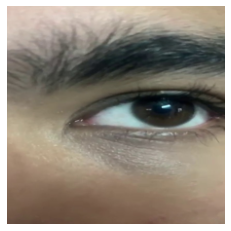

In [15]:
img_path = test_dir + '/open/img56.jpg'
img, top_p, top_classes, real_class = predict(img_path, model1)
_ = imshow_tensor(img)
print(top_p, top_classes, real_class)

In [16]:
model1.eval()
torch.exp(model1(process_image(img_path).view(1,3,224,224)))

tensor([[9.0469e-13, 1.0000e+00]], grad_fn=<ExpBackward>)

In [22]:
import cv2
font = cv2.FONT_HERSHEY_SIMPLEX
video = '/home/shrey/Desktop/final_test.avi'
cap = cv2.VideoCapture(video)

while cap.isOpened():
    plot = np.zeros((300,500,3),dtype='uint8')
    if cv2.waitKey(5)==ord('q'):
        break
    ret,frame = cap.read()
    frame = frame.transpose((1,0,2))
    #frame = cv2.rectangle(frame,(250,100),(500,400),(0,255,0),2)
    #img = frame[102:398,252:498]
    cv2.imwrite('video2.jpg',frame)
    img_path = '/home/shrey/Desktop/Pytorch/video2.jpg'
    img_saved = cv2.imread(img_path)
    img,top_p,top_classes,real_class = predict(img_path,model1)
    img_saved = cv2.putText(img_saved,top_classes[0],(50,100),font,3,(0,0,0),3,cv2.LINE_AA)
    for class_,idx in model1.class_to_idx.items():
            cv2.putText(plot,class_,(200*idx+100,295),font,1,(0,255,0),2,cv2.LINE_AA)
            out = torch.exp(model1(process_image(img_path).view(1,3,224,224))).detach().numpy()[0]
            #plot = cv2.rectangle(plot,(100*idx,290),(100*idx+5,290-200*out[idx]),(0,0,255),-1)
            plot = cv2.rectangle(plot,(200*idx+100,260),(200*idx+105,int(260-200*out[idx])),(0,0,255),-1)
    cv2.imshow('frame',img_saved)
    cv2.imshow('plot',plot)
    
cap.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'transpose'

In [23]:
cap.release()
cv2.destroyAllWindows()